# Image classification

## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
import shutil
import seaborn as sns
#import glob

Mount Google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
workdir ='/content/drive/My Drive/data/distracted/'
#workdir ='/content/drive/My Drive/data/Sample/'

In [7]:
!ls /content/drive/My\ Drive/data/distracted

driver_imgs_list.csv  imgs  sample_submission.csv


## Load data

In [8]:
import pandas as pd
imgs_list_df = pd.read_csv(workdir+'driver_imgs_list.csv')
imgs_list_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [9]:
print(os.listdir(workdir+'imgs/'))
data_dir = workdir+'imgs/'

['train', 'test']


The dataset has the following directory structure:

<pre>
<b>imgs</b>
|__ <b>train</b>
    |______ <b>c0</b>: [img_844.jpg, ....]
    |______ <b>c1</b>: [img_9820.jpg,  ...]
|__ <b>test</b>
    |______ img_0297.jpg
    |______ img_8269.jpg
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

For convenience, set up variables to use while pre-processing the dataset and training the network.

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [0]:

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE=64

In [52]:

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        data_dir+"train/",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training")

val_generator = val_datagen.flow_from_directory(
        data_dir+"train/",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation")

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


In [0]:
total_train =15702 
total_val = 6722

In [0]:
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

col = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5':'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [14]:
for label in labels:
    f, ax = plt.subplots(figsize=(12, 10))
    files = glob('{}/train/{}/*.jpg'.format(data_dir, label))
    
    print('\t\t\t\t# {} : {}'.format(label, col[label]))
    for x in range(2):
        plt.subplot(1, 2, x+1)
        image = read_image(files[x])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Create the model 1

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu`` activation function.

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

### Model summary

View all the layers of the network using the model's `summary` method:

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

### Visualize training results

Now visualize the results after training the network.

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

In [21]:
model1.save(workdir+'/classifier1.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/distracted//classifier1.model/assets


## Create the model 2 :  softmax activation and adam optimizer 

I'll develop the model with a total of 3 Convolutional layers, then a Flatten layer and then 3 Dense layers. I'll use the optimizer as adam, and loss as categorical_crossentropy.

In [55]:
model2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'), 
    Dense(10, activation='softmax')
])
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 20736)            

In [56]:
#BATCH_SIZE = 64
epochs = 30
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_val // BATCH_SIZE
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245 steps, validate for 105 steps
Epoch 1/30
245/245 [==============================] - 122s 498ms/step - loss: 0.6050 - accuracy: 0.8004 - val_loss: 0.1344 - val_accuracy: 0.9625
Epoch 2/30
245/245 [==============================] - 120s 491ms/step - loss: 0.0570 - accuracy: 0.9829 - val_loss: 0.0599 - val_accuracy: 0.9824
Epoch 3/30
245/245 [==============================] - 122s 499ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0445 - val_accuracy: 0.9881
Epoch 4/30
245/245 [==============================] - 121s 494ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.0476 - val_accuracy: 0.9887
Epoch 5/30
245/245 [==============================] - 121s 496ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0441 - val_accuracy: 0.9911
Epoch 6/30
245/245 [==============================] - 122s 500ms/step - loss: 0.0076 - accuracy: 0.9983 - val_loss: 0.0245 - val_accuracy: 0.9942
Epoch 7/30
245/245 [==========

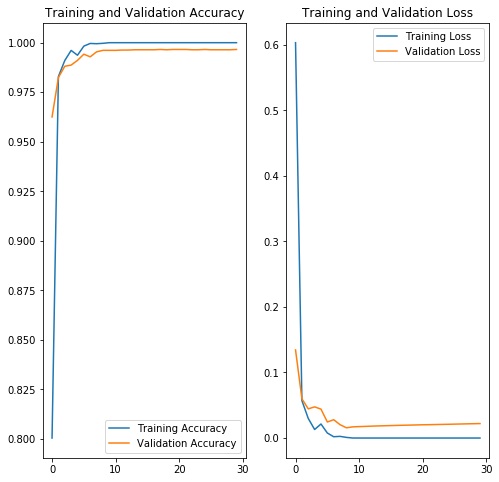

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
model2.save(workdir+'/classifier2.model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/distracted//classifier2.model/assets


## Create the model 2 :  softmax activation and adam sgd

In [63]:
model21 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'), 
    Dense(10, activation='softmax')
])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model21.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model21.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 20736)            

In [64]:
#BATCH_SIZE = 64
epochs = 30
history = model21.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_val // BATCH_SIZE
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245 steps, validate for 105 steps
Epoch 1/30
245/245 [==============================] - 122s 497ms/step - loss: 0.9835 - accuracy: 0.6636 - val_loss: 0.2029 - val_accuracy: 0.9409
Epoch 2/30
245/245 [==============================] - 126s 514ms/step - loss: 0.0966 - accuracy: 0.9734 - val_loss: 0.0791 - val_accuracy: 0.9795
Epoch 3/30
245/245 [==============================] - 123s 501ms/step - loss: 0.0406 - accuracy: 0.9880 - val_loss: 0.0453 - val_accuracy: 0.9882
Epoch 4/30
245/245 [==============================] - 121s 494ms/step - loss: 0.0231 - accuracy: 0.9923 - val_loss: 0.0347 - val_accuracy: 0.9902
Epoch 5/30
245/245 [==============================] - 122s 496ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.0309 - val_accuracy: 0.9927
Epoch 6/30
245/245 [==============================] - 121s 492ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0328 - val_accuracy: 0.9932
Epoch 7/30
245/245 [==========

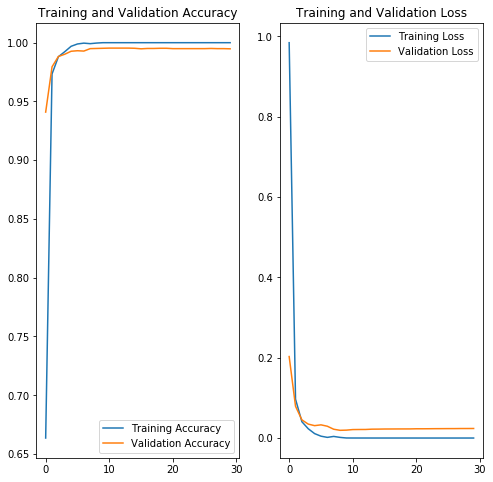

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
model21.save(workdir+'/classifier21.model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/distracted//classifier21.model/assets


##Create the model 3: sigmoid activation and adam optimizer

In [0]:
def create_model(activation,optimizer):
  model = Sequential([
      Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(512, activation='relu'), 
      Dense(10, activation=activation)
  ])
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [0]:
model3 = create_model('sigmoid','adam')

In [70]:
BATCH_SIZE = 64
epochs = 10
filepath=workdir+"weights_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model3.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_val // BATCH_SIZE,
 callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245 steps, validate for 105 steps
Epoch 1/10
245/245 [==============================] - 123s 502ms/step - loss: 0.7584 - accuracy: 0.7455 - val_loss: 0.0985 - val_accuracy: 0.9725
Epoch 2/10
245/245 [==============================] - 120s 490ms/step - loss: 0.0669 - accuracy: 0.9827 - val_loss: 0.0495 - val_accuracy: 0.9859
Epoch 3/10
245/245 [==============================] - 120s 489ms/step - loss: 0.0254 - accuracy: 0.9929 - val_loss: 0.1311 - val_accuracy: 0.9592
Epoch 4/10
245/245 [==============================] - 120s 492ms/step - loss: 0.0262 - accuracy: 0.9912 - val_loss: 0.0433 - val_accuracy: 0.9884
Epoch 5/10
245/245 [==============================] - 120s 488ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.0266 - val_accuracy: 0.9929
Epoch 6/10
245/245 [==============================] - 121s 492ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.0322 - val_accuracy: 0.9924
Epoch 7/10
245/245 [==========

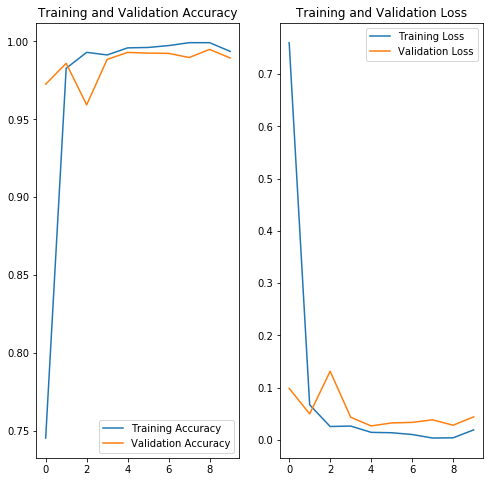

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
model3.save(workdir+'/classifier3.model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/distracted//classifier3.model/assets


## Create the model 3: sigmoid activation and and SGD optimizer

In [0]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model31 = create_model('sigmoid', sgd)

In [74]:
BATCH_SIZE = 64
epochs = 10
filepath=workdir+"weights_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model31.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_val // BATCH_SIZE,
 callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245 steps, validate for 105 steps
Epoch 1/10
245/245 [==============================] - 122s 498ms/step - loss: 1.4066 - accuracy: 0.5015 - val_loss: 0.3223 - val_accuracy: 0.9019
Epoch 2/10
245/245 [==============================] - 121s 493ms/step - loss: 0.1305 - accuracy: 0.9627 - val_loss: 0.0889 - val_accuracy: 0.9765
Epoch 3/10
245/245 [==============================] - 120s 491ms/step - loss: 0.0457 - accuracy: 0.9867 - val_loss: 0.0601 - val_accuracy: 0.9833
Epoch 4/10
245/245 [==============================] - 123s 503ms/step - loss: 0.0221 - accuracy: 0.9935 - val_loss: 0.0484 - val_accuracy: 0.9860
Epoch 5/10
245/245 [==============================] - 122s 498ms/step - loss: 0.0194 - accuracy: 0.9953 - val_loss: 0.0417 - val_accuracy: 0.9888
Epoch 6/10
245/245 [==============================] - 120s 489ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.0427 - val_accuracy: 0.9874
Epoch 7/10
245/245 [==========

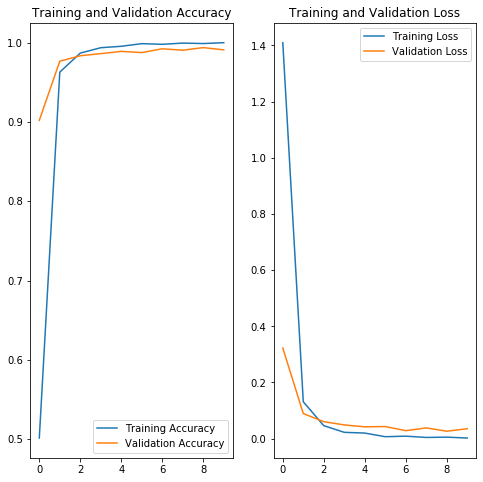

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
model31.save(workdir+'/classifier31.model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/distracted//classifier31.model/assets


## TEST model 2

In [0]:
def get_data(image_path):
    img = Image.open(image_path)
    img = img.resize(IMG_HEIGHT, IMG_WIDTH, Image.ANTIALIAS) # resizes image in-place
    return np.asarray(img)/255

In [78]:
test_file = pd.read_csv(workdir+'sample_submission.csv')
test_file.head(5)

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [79]:
%%time
for i, file in enumerate(test_file['img']):
  img_path = workdir+'/test/'+ file
  if os.path.exists(img_path):
    image = get_data(img_path)
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    result = model2.predict(image)
    test_file.iloc[i, 1:] = result[0]

CPU times: user 1.33 s, sys: 1.24 s, total: 2.57 s
Wall time: 6.59 s


In [80]:
test_file.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [0]:
test_file.to_csv(workdir+'model2_results.csv', index = False)